# This is the demo of TAC-GAN on MOG (mixture of gaussian) 

Load the needed package

# Import and libraries

In [1]:
%matplotlib inline
import os
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from mmd_metric import polynomial_mmd
import pdb

# Classes for cGAN

In [2]:
#######G network

#####D network
class D_guassian(nn.Module):

    def __init__(self, num_classes=10,AC=True):
        super(D_guassian, self).__init__()

        self.AC = AC

        self.encode = nn.Sequential(

            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            # nn.Tanh(),
        )
        self.gan_linear = nn.Linear(10, 1)
        self.aux_linear = nn.Linear(10, num_classes)
        self.mi_linear = nn.Linear(10, num_classes)

        if not self.AC:
            self.projection = nn.Embedding(num_embeddings=num_classes,embedding_dim=10)

        self.sigmoid = nn.Sigmoid()
        self.__initialize_weights()

    def forward(self, input,y=None):

        x = self.encode(input)
        x = x.view(-1, 10)
        c = self.aux_linear(x)
        mi = self.mi_linear(x)

        s = self.gan_linear(x)
        if not self.AC:
            s += (self.projection(y)*x).sum(dim=1,keepdim=True)
        s = self.sigmoid(s)
        return s.squeeze(1), c.squeeze(1), mi.squeeze(1)

    def __initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)

# Helper functions to plot the results

In [3]:
def plot_density(flights,binwidth=0.1):
    ax = plt.subplot(1,1,1)

    # Draw the plot
    ax.hist(flights, bins=int(180 / binwidth),
            color='blue', edgecolor='black')

    # Title and labels
    ax.set_title('Histogram with Binwidth = %d' % binwidth, size=30)
    ax.set_xlabel('Delay (min)', size=22)
    ax.set_ylabel('Flights', size=22)

    plt.tight_layout()
    plt.show()

# Runner

In [41]:
####TAC-GAN: set AC=True, MI=True, AC-GAN:set AC=True, MI=False, Projection-GAN: set AC=False, MI=False
def train(data1, data2, data3, nz, D, optd, bs=None):
    bs = [128, 128, 128] if bs is None else bs
    for _ in range(50):
        for i in range(1000):
            data = torch.cat(
                [data1[bs[0] * i:bs[0] * i + bs[0]], data2[bs[1] * i:bs[1] * i + bs[1]], data3[bs[2] * i:bs[2] * i + bs[2]]],
                dim=0).unsqueeze(dim=1)
            label = torch.cat([torch.ones(bs[0]).cuda().long()*0, torch.ones(bs[1]).cuda().long()*1, torch.ones(bs[2]).cuda().long()*2],dim=0)
            idx = torch.randperm(sum(bs))
            data = data[idx, ...]
            label = label[idx, ...]
            ###D
            d_real, c, _ = D(data)

            D_loss = F.cross_entropy(c, label)

            optd.zero_grad()
            D_loss.backward()
            optd.step()


# Visualize and evaluation

Running the 1-D MOG toy experiments of different distance between different gaussian components. Cost about 10 min in 1080ti

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


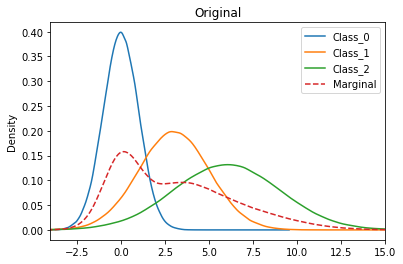

In [5]:

######create folder to save the result
distance = 3
if os.path.exists(os.path.join('MOG','1D', str(distance) + '_1D')):
    pass
else:
    os.makedirs(os.path.join('MOG','1D', str(distance) + '_1D'))
save_path = os.path.join('MOG','1D', str(distance) + '_1D')

######Generate MOG data of different mean and variance
data1 = torch.randn(128000).cuda()
data2 = torch.randn(128000).cuda() * 2 + distance
data3 = torch.randn(128000).cuda() * 3 + distance * 2

df1 = pd.DataFrame()
df2 = pd.DataFrame()

df1['score_{0}'.format(0)] = data1.cpu().numpy()
df1['score_{0}'.format(1)] = data2.cpu().numpy()
df1['score_{0}'.format(2)] = data3.cpu().numpy()
r_data = torch.cat([data1, data2, data3], dim=0).cpu().numpy()
df2['score_{0}'.format(2)] = r_data
np.save(save_path+'/o_data',r_data)

######Plot the distribution of original data
fig, ax = plt.subplots(1, 1)
for s in df1.columns:
    df1[s].plot(kind='kde')

for s in df2.columns:
    df2[s].plot(style='--',kind='kde')
plt.xlim((-4, 9 + distance * 2))
ax.legend(["Class_0", "Class_1","Class_2","Marginal"])
plt.title('Original')
fig.savefig(save_path + '/original.eps')

# Build Network

In [15]:
####TAC-GAN: set AC=True, MI=True, AC-GAN:set AC=True, MI=False, Projection-GAN: set AC=False, MI=False
##Default TAC-GAN
AC = True

#####Bulding network
nz = 2

D = D_guassian(num_classes=3, AC=AC).cuda()

optd = optim.Adam(D.parameters(), lr=0.002,
                      betas=(0.5, 0.999))

In [44]:
#####Train network
train(data1, data2, data3, nz, D, optd, [4, 4, 128])
print('Training finished')

Training finished


In [45]:
#####Save Q(y|x) predictions
c_ = []
x_ = []
for i in range(1000):
    data = torch.cat(
        [data1[128 * i:128 * i + 128], data2[128 * i:128 * i + 128], data3[128 * i:128 * i + 128]],
        dim=0).unsqueeze(dim=1)
    label = torch.cat([torch.ones(128).cuda().long()*0, torch.ones(128).cuda().long()*1, torch.ones(128).cuda().long()*2], dim=0)
    _, c, _ = D(data)
    c_.append(c.detach())
    x_.append(data)
c = torch.cat(c_)
c_numpy = c.cpu().numpy()
x = torch.cat(x_)
x_numpy = x.cpu().numpy()
np.save('logits_2.npy', c_numpy)
np.save('inputs_2.npy', x_numpy)

# Evaluate the MMD distance between true data and generated data

the distance of class 0 is :  0.008205491237123663
the distance of class 1 is :  1.5177659917671917
the distance of class 2 is :  0.781029228938678
the distance of marginal is :  -0.11618767918389494
